In [2]:
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

In [44]:
def dataframe_subset_i0(df):
    subset = df.loc[:, (df.columns == 'eid') | df.columns.str.contains(r'i0')]
    return(subset)

In [3]:
# Fluid Intelligence
df_FI = pd.read_csv('fluid_intelligence.tsv', sep="\t")
df_FI
# df_FI = dataframe_subset_i0(df_FI)

# # Dropping fields
# df_FI = df_FI.drop(['p20191_i0', 'p20192_i0', 'p20128_i0'], axis=1)
# df_FI = df_FI.rename(columns={'p20016_i0': 'FI_acc'})
# df_FI

,eid,p20016_i0,p20016_i1,p20016_i2,p20016_i3,p20191_i0,p20191_i1,p20128_i0,p20128_i1,p20128_i2,p20128_i3,p20192_i0,p20192_i1
0,1672172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2840420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2074456,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,7.0
3,3728886,10.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
4,3315771,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502159,3970763,NaN,NaN,9.0,NaN,NaN,7.0,NaN,NaN,10.0,NaN,NaN,7.0
502160,5351259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502161,5400162,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN
502162,4475212,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0


In [46]:
# Numeric Memory
df_NM = pd.read_csv('numeric_memory.tsv', sep="\t")
df_NM = dataframe_subset_i0(df_NM)
df_NM

df_NM = df_NM.drop(['p20240_i0', 'p4285_i0'], axis=1)
df_NM = df_NM.rename(columns={'p4282_i0': 'NM_acc'})
df_NM
# Accuracy
# df_NM = df_NM.rename(columns={'p4282_i0': 'NM_acc'})

,eid,NM_acc
0,1672172,NaN
1,2840420,NaN
2,2074456,NaN
3,3728886,NaN
4,3315771,NaN
...,...,...
502159,3970763,NaN
502160,5351259,6.0
502161,5400162,NaN
502162,4475212,NaN


In [62]:
# Pairs Matching
df_PM = pd.read_csv('pairs_matching.tsv', sep="\t")
df_PM_ic = pd.read_csv('pairs_matching_incorrect.tsv', sep="\t")
df_PM = pd.merge(df_PM, df_PM_ic, on='eid')
df_PM = dataframe_subset_i0(df_PM)

pattern = r'(eid|398.*|400.*|399.*)'
df_PM = df_PM.filter(regex=pattern)

df_PM = df_PM.drop(['p398_i0_a3', 'p400_i0_a3', 'p399_i0_a3'], axis=1)

# Calculating based on paper
df_PM['p398_i0_a1'] = df_PM['p398_i0_a1'] * 2
df_PM['p398_i0_a2'] = df_PM['p398_i0_a2'] * 2

df_PM['PM_acc'] = df_PM['p398_i0_a1'] + df_PM['p398_i0_a2'] - df_PM['p399_i0_a1'] - df_PM['p399_i0_a2']

df_PM['PM_spd'] = df_PM['p400_i0_a1'] + df_PM['p400_i0_a2']

pattern = r'(eid|PM.*)'
df_PM = df_PM.filter(regex=pattern)

# # # Check for non-positive values excluding NaN
# # non_positive_values = ((df_PM.le(0)) & (df_PM.notna())).sum()

# # print("Non-positive values (excluding NaN):")
# # print(non_positive_values)
# rows_with_non_positive = df_PM[((df_PM.le(0)) & (df_PM.notna())).any(axis=1)]
# print("Rows with non-positive values (excluding NaN):")
# print(rows_with_non_positive)

df_PM['PM_spd'] = -np.log(df_PM['PM_spd'], where= (df_PM['PM_spd'] != "NaN"))
df_PM['PM_spd'] = df_PM['PM_spd'].replace([np.inf, -np.inf], np.nan)

/home/pdutta/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
# Prospective Memory
df_PRM = pd.read_csv('prospective_memory.tsv', sep="\t")
df_PRM = dataframe_subset_i0(df_PRM)
df_PRM['PRM_spd'] = -np.log(df_PRM['p4288_i0'], where=df_PRM['p4288_i0'] != 'NaN')

df_PRM.loc[df_PRM['p20018_i0'] == 1, "p20018_i0"] =3
df_PRM.loc[df_PRM['p20018_i0'] == 2, "p20018_i0"] =1
df_PRM.loc[df_PRM['p20018_i0'] == 3, "p20018_i0"] =2

df_PRM = df_PRM.rename(columns={'p20018_i0': 'PRM_acc'})
df_PRM = df_PRM.drop(['p4288_i0'], axis=1)

df_PRM

,eid,PRM_acc,PRM_spd
0,1672172,NaN,NaN
1,2840420,NaN,NaN
2,2074456,NaN,NaN
3,3728886,2.0,-5.991465
4,3315771,NaN,NaN
...,...,...,...
502159,3970763,NaN,NaN
502160,5351259,1.0,-6.322565
502161,5400162,NaN,NaN
502162,4475212,NaN,NaN


In [49]:
# Reaction Time
df_RT = pd.read_csv('reaction_time.tsv', sep="\t")
df_RT_dur = pd.read_csv('duration_to_press_button.tsv', sep="\t")

df_RT = pd.merge(df_RT, df_RT_dur, on='eid')
df_RT = dataframe_subset_i0(df_RT)
pattern = r'(eid|20023.*|404.*)'
df_RT = df_RT.filter(regex=pattern)
df_RT['RT_acc'] = -np.log(df_RT['p20023_i0'], where=df_RT['p20023_i0'] != 'NaN')

pattern = r'(404.*)'
df_RT_subset = df_RT.filter(regex=pattern)
df_RT_subset.loc[:, 'RT_spd'] = df_RT_subset.sum(axis=1)
df_RT['RT_spd'] = df_RT_subset['RT_spd']/12
df_RT['RT_spd'] = df_RT['RT_spd'].replace(0, np.nan)
df_RT['RT_spd'] = -np.log(df_RT['RT_spd'], where=df_RT['RT_spd'] != 'NaN')

pattern = r'(eid|RT.*)'
df_RT = df_RT.filter(regex=pattern)
df_RT

/tmp/ipykernel_2846/3066270054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RT_subset.loc[:, 'RT_spd'] = df_RT_subset.sum(axis=1)


,eid,RT_acc,RT_spd
0,1000015,-6.469250,-5.706556
1,1000053,-6.413459,-5.706556
2,1000132,-6.175867,-5.506009
3,1000148,-6.504288,-5.808893
4,1000163,-6.289716,-5.606721
...,...,...,...
502159,6024061,NaN,NaN
502160,6024074,-6.456770,-5.777910
502161,6024106,-6.572283,-5.930254
502162,6024120,-6.291569,-5.582870


In [63]:
# Symbol Digit Subtitution
df_SDS = pd.read_csv('symbol_digit_substitution.tsv', sep="\t")
df_SDS = dataframe_subset_i0(df_SDS)
pattern = r'(eid|20159.*|20230.*)'
df_SDS = df_SDS.filter(regex=pattern)
df_SDS = df_SDS.rename(columns={'p20159_i0': 'SDS_acc'})

pattern = r'(20230.*)'
df_SDS_sub = df_SDS.filter(regex=pattern)
df_SDS['SDS_spd'] = df_SDS_sub.sum(axis=1)
df_SDS["SDS_acc"] = df_SDS["SDS_acc"].replace(0, np.nan)
df_SDS['SDS_spd'] = df_SDS['SDS_spd'].replace(0, np.nan)
df_SDS['SDS_spd'] = df_SDS['SDS_spd']/df_SDS['SDS_acc']
df_SDS['SDS_spd'] = -np.log(df_SDS['SDS_spd'], where=df_SDS['SDS_spd'] != 'NaN')
df_SDS['SDS_spd'] = df_SDS['SDS_spd'].replace([np.inf, -np.inf], np.nan)

pattern = r'(eid|SDS)'
df_SDS = df_SDS.filter(regex=pattern)
df_SDS

/home/pdutta/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,eid,SDS_acc,SDS_spd
0,1000015,NaN,NaN
1,1000053,NaN,NaN
2,1000132,NaN,NaN
3,1000148,NaN,NaN
4,1000163,28.0,-7.593230
...,...,...,...
502159,6024061,NaN,NaN
502160,6024074,22.0,-7.838630
502161,6024106,NaN,NaN
502162,6024120,26.0,-7.655682


In [51]:
# Trail Making
df_TM = pd.read_csv('trail_making.tsv', sep="\t")
df_TM = dataframe_subset_i0(df_TM)
df_TM = df_TM.rename(columns={'p20156_i0': 'TM_num_spd', 'p20157_i0': 'TM_anum_spd'})
df_TM['TM_num_spd'] = -np.log(df_TM['TM_num_spd'], where=df_TM['TM_num_spd'] != 'NaN')
df_TM['TM_anum_spd'] = -np.log(df_TM['TM_anum_spd'], where=df_TM['TM_anum_spd'] != 'NaN')
pattern = r'(eid|TM.*)'
df_TM = df_TM.filter(regex=pattern)
df_TM

,eid,TM_num_spd,TM_anum_spd
0,1672172,NaN,NaN
1,2840420,NaN,NaN
2,2074456,NaN,NaN
3,3728886,NaN,NaN
4,3315771,NaN,NaN
...,...,...,...
502159,3970763,NaN,NaN
502160,5351259,NaN,NaN
502161,5400162,-3.920646,-4.183042
502162,4475212,NaN,NaN


In [82]:
#Mergingin all dataframes
from functools import reduce

data_frames= [df_FI, df_NM, df_PM, df_PRM, df_RT, df_SDS, df_TM]

cog_df = reduce(lambda  left,right: pd.merge(left,right,on=['eid'],
                                            how='outer'), data_frames)
cog_df = cog_df.set_index('eid')

print(cog_df.isnull().mean() * 100)

for column in cog_df.columns: 
    cog_df[column] = (cog_df[column] -
                           cog_df[column].mean()) / cog_df[column].std() 

print(cog_df.isnull().mean() * 100)

cog_df= cog_df[["FI_acc", "NM_acc", "PM_acc", "PRM_acc", "RT_acc", "SDS_acc", "PM_spd", "PRM_spd", "RT_spd", "SDS_spd", "TM_num_spd", "TM_anum_spd"]]
cog_df

FI_acc         67.072709
NM_acc         89.689225
PM_acc          0.919819
PM_spd          3.319832
PRM_acc        65.861551
PRM_spd        65.861551
RT_acc          1.159382
RT_spd          1.842227
SDS_acc        76.472228
SDS_spd        76.472427
TM_num_spd     79.296206
TM_anum_spd    79.296604
dtype: float64
FI_acc         67.072709
NM_acc         89.689225
PM_acc          0.919819
PM_spd          3.319832
PRM_acc        65.861551
PRM_spd        65.861551
RT_acc          1.159382
RT_spd          1.842227
SDS_acc        76.472228
SDS_spd        76.472427
TM_num_spd     79.296206
TM_anum_spd    79.296604
dtype: float64


,FI_acc,NM_acc,PM_acc,PRM_acc,RT_acc,SDS_acc,PM_spd,PRM_spd,RT_spd,SDS_spd,TM_num_spd,TM_anum_spd
eid,,,,,,,,,,,,
1672172,NaN,NaN,0.739627,NaN,1.562504,NaN,0.818771,NaN,1.337338,NaN,NaN,NaN
2840420,NaN,NaN,NaN,NaN,-1.445501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2074456,NaN,NaN,-0.874610,NaN,-0.809608,NaN,0.046744,NaN,-0.415943,NaN,NaN,NaN
3728886,1.861967,NaN,0.047811,0.519850,1.003292,NaN,0.395414,0.431621,1.258167,NaN,NaN,NaN
3315771,NaN,NaN,0.739627,NaN,0.292980,NaN,0.252769,NaN,0.277831,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3970763,NaN,NaN,0.970232,NaN,-0.205685,NaN,1.008839,NaN,-1.115011,NaN,NaN,NaN
5351259,NaN,-0.257324,-0.874610,-1.285116,NaN,NaN,-2.692608,-0.862195,NaN,NaN,NaN,NaN
5400162,NaN,NaN,0.278417,NaN,1.049611,-0.332369,0.098291,NaN,1.193149,-0.204256,-0.946845,-0.12453


In [65]:
prs_df= pd.read_csv('prs_scaled', sep="\t")
prs_df.rename(columns = {'Participant_ID':'eid'}, inplace = True)
merged_df = pd.merge(cog_df, prs_df, on='eid')
merged_df
merged_df = merged_df.rename(columns={"SCZ_PGS_Score": "SCZ_PGS", "BD_PGS_Score": "BD_PGS", "WR_PGS_Score": "WR_PGS", "EA_PGS_Score": "EA_PGS", "DYX_PGS_Score": "DYX_PGS", "MDD_PGS_Score": "MDD_PGS"})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498015 entries, 0 to 498014
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   eid          498015 non-null  int64  
 1   FI_acc       163712 non-null  float64
 2   NM_acc       51431 non-null   float64
 3   PM_acc       493959 non-null  float64
 4   PRM_acc      169431 non-null  float64
 5   RT_acc       492797 non-null  float64
 6   SDS_acc      117681 non-null  float64
 7   PM_spd       482458 non-null  float64
 8   PRM_spd      169431 non-null  float64
 9   RT_spd       489525 non-null  float64
 10  SDS_spd      117680 non-null  float64
 11  TM_num_spd   103570 non-null  float64
 12  TM_anum_spd  103568 non-null  float64
 13  SCZ_PGS      406842 non-null  float64
 14  BD_PGS       406842 non-null  float64
 15  WR_PGS       406842 non-null  float64
 16  EA_PGS       406842 non-null  float64
 17  DYX_PGS      406842 non-null  float64
 18  MDD_PGS      406842 non-

In [54]:
def perform_correlation(pheno_df, phenotype):
    df = pd.DataFrame()
    feats = []
    corrs = []
    p_values = []

    for feat in pheno_df.columns:
        if feat != phenotype:
            feats.append(feat)
            corr, p_value = scipy.stats.spearmanr(pheno_df[phenotype], pheno_df[feat], nan_policy='omit')
            corrs.append(corr)
            p_values.append(p_value)
    
    df['Feature'] = feats
    df[phenotype] = corrs
    df['p_value'] = p_values
    df
    
    from statsmodels.sandbox.stats.multicomp import multipletests
    p_adjusted = multipletests(p_values, method='bonferroni')
    
    df['p_adj'] = p_adjusted[1]
    
    new_df = df.iloc[: , 0:2]
    new_df = new_df.set_index('Feature')
    
    #plot matrix
    sns.heatmap(new_df,annot=True, vmin=-0.2, vmax=0.2, annot_kws={'size':11},cmap="inferno")
    file= phenotype+"_psych_corr.png"
    plt.savefig(file,dpi=300, bbox_inches = "tight")
    plt.show()
    
    return(df)

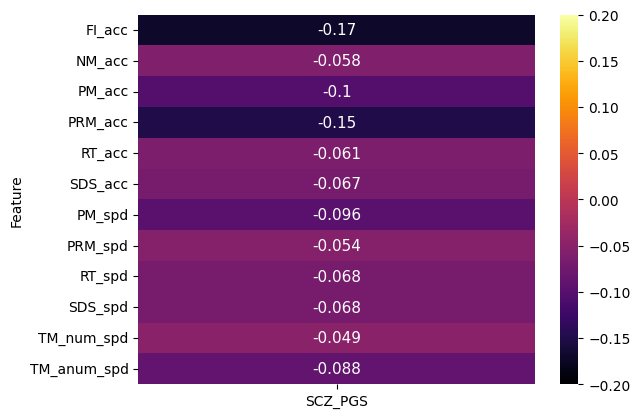

In [66]:
pattern = r'(acc.*|spd.*|SCZ)'
SCZ_df = merged_df.filter(regex=pattern)
SCZ_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_SCZ = perform_correlation(SCZ_df, "SCZ_PGS")

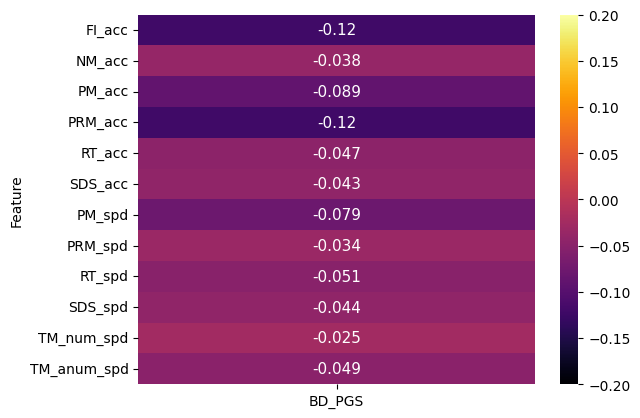

In [67]:
pattern = r'(acc.*|spd.*|BD)'
BD_df = merged_df.filter(regex=pattern)
BD_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_BD = perform_correlation(BD_df, "BD_PGS")

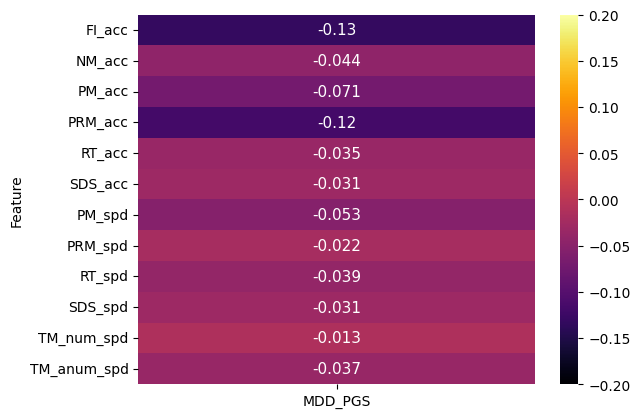

In [68]:
pattern = r'(acc.*|spd.*|MDD)'
MDD_df = merged_df.filter(regex=pattern)
MDD_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_MDD = perform_correlation(MDD_df, "MDD_PGS")

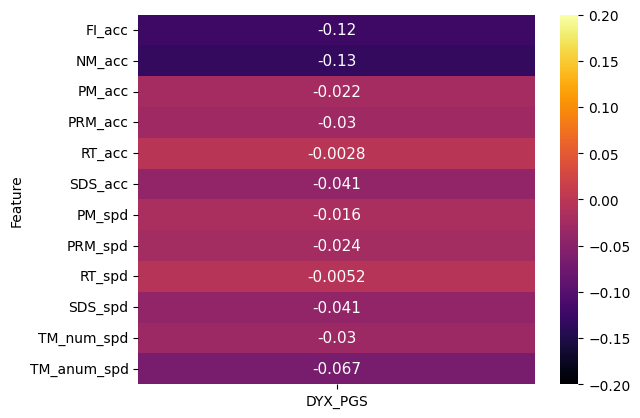

In [69]:
pattern = r'(acc.*|spd.*|DYX)'
DYX_df = merged_df.filter(regex=pattern)
DYX_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_DYX = perform_correlation(DYX_df, "DYX_PGS")

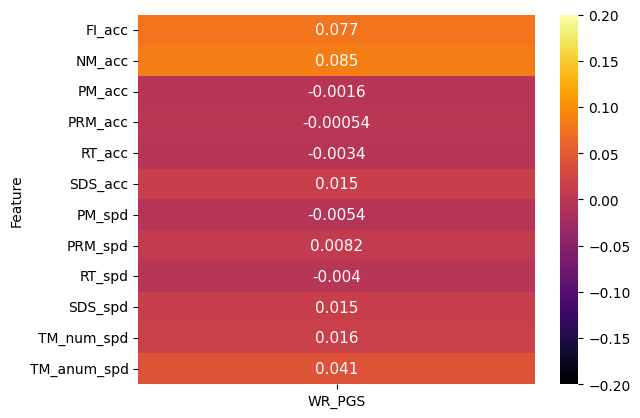

In [70]:
pattern = r'(acc.*|spd.*|WR)'
WR_df = merged_df.filter(regex=pattern)
WR_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_SCZ = perform_correlation(WR_df, "WR_PGS")

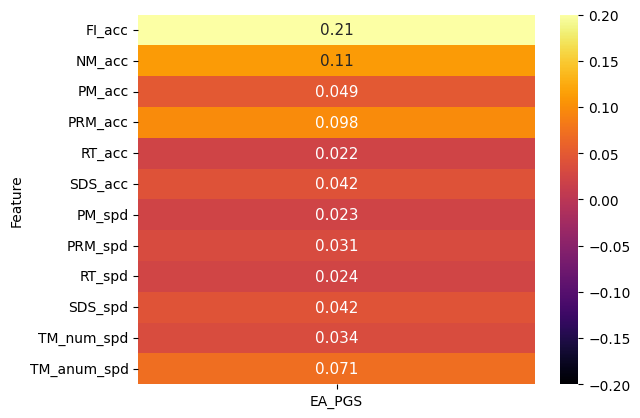

In [71]:
pattern = r'(acc.*|spd.*|EA)'
EA_df = merged_df.filter(regex=pattern)
EA_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_EA = perform_correlation(EA_df, "EA_PGS")

In [72]:
psych_patients = pd.read_csv('data_participant_psych.tsv', sep="\t")
psych_patients

,eid
0,4321092
1,5180505
2,5457093
3,4799899
4,4748722
...,...
35916,5718324
35917,4597023
35918,4083151
35919,4518397


In [74]:
df_psych = pd.merge(merged_df, psych_patients, on='eid')
df_psych

,eid,FI_acc,NM_acc,PM_acc,PRM_acc,RT_acc,SDS_acc,PM_spd,PRM_spd,RT_spd,SDS_spd,TM_num_spd,TM_anum_spd,SCZ_PGS,BD_PGS,WR_PGS,EA_PGS,DYX_PGS,MDD_PGS
0,4321092,NaN,NaN,-2.027636,NaN,-0.710914,NaN,-1.858422,NaN,-1.256267,NaN,NaN,NaN,0.616964,0.167623,-0.557026,0.395385,1.391325,1.007940
1,5180505,NaN,NaN,-0.182794,NaN,-1.064023,NaN,-1.160379,NaN,4.578010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5457093,0.935881,NaN,0.970232,0.519850,-0.047840,-0.138769,1.134264,1.020979,0.020993,-0.017371,0.775918,1.227621,-1.279411,-1.276617,1.022797,1.649672,-0.866336,0.561072
3,4799899,0.935881,0.288407,0.970232,0.519850,0.282927,NaN,0.907461,-0.645851,0.294721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4748722,NaN,NaN,-0.874610,-3.090082,NaN,NaN,-1.737410,2.560207,NaN,NaN,NaN,NaN,0.231710,-0.810562,-2.178400,0.321786,0.157692,0.158646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35600,5718324,NaN,NaN,-1.335820,NaN,-0.809608,NaN,-1.916778,NaN,-0.718099,NaN,NaN,NaN,0.452195,1.034730,1.393945,0.317022,0.188185,0.181750
35601,4597023,NaN,NaN,0.970232,NaN,0.134412,NaN,1.461821,NaN,0.468474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35602,4083151,NaN,NaN,-0.413399,NaN,-0.874383,0.248432,-2.553912,NaN,-0.681642,0.282092,0.364458,-0.230353,NaN,NaN,NaN,NaN,NaN,NaN
35603,4518397,0.935881,NaN,0.509022,0.519850,1.287576,NaN,-0.201794,0.149019,1.171053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


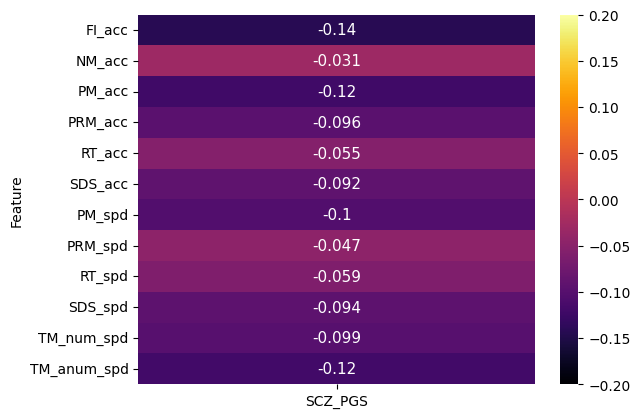

In [75]:
pattern = r'(acc.*|spd.*|SCZ)'
SCZ_df = df_psych.filter(regex=pattern)
SCZ_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_SCZ = perform_correlation(SCZ_df, "SCZ_PGS")

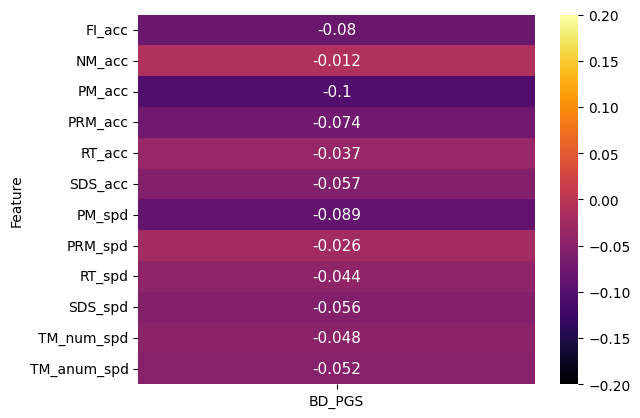

In [76]:
pattern = r'(acc.*|spd.*|BD)'
BD_df = df_psych.filter(regex=pattern)
BD_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_BD = perform_correlation(BD_df, "BD_PGS")

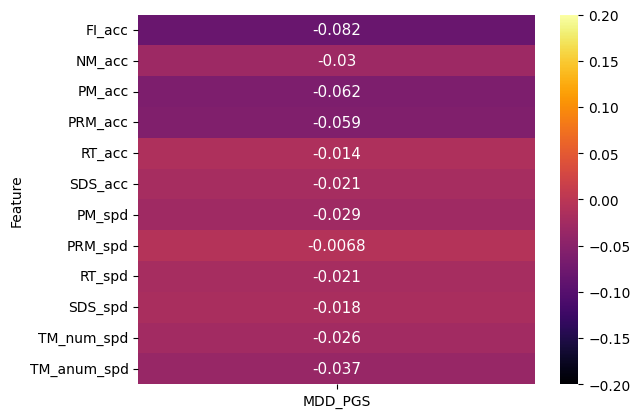

In [77]:
pattern = r'(acc.*|spd.*|MDD)'
MDD_df = df_psych.filter(regex=pattern)
MDD_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_MDD = perform_correlation(MDD_df, "MDD_PGS")

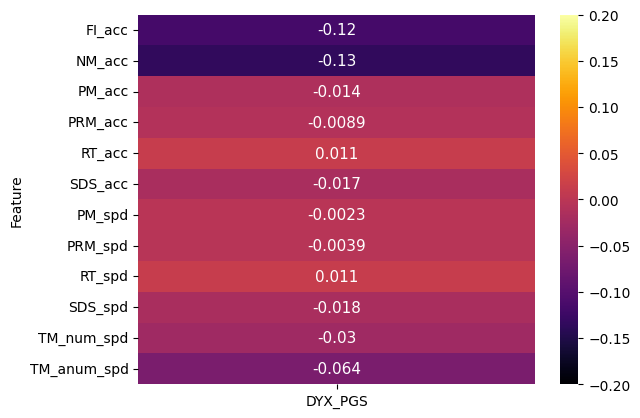

In [78]:
pattern = r'(acc.*|spd.*|DYX)'
DYX_df = df_psych.filter(regex=pattern)
DYX_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_DYX = perform_correlation(DYX_df, "DYX_PGS")

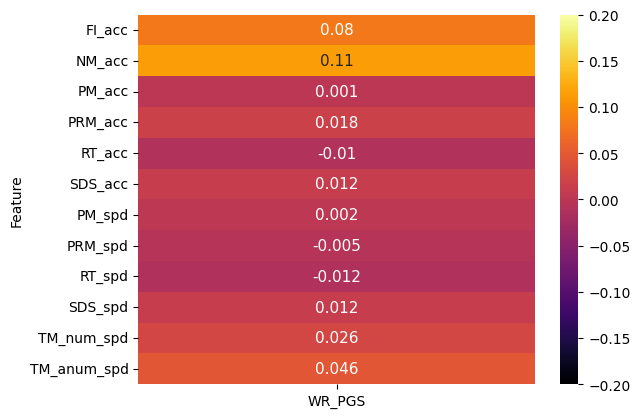

In [79]:
pattern = r'(acc.*|spd.*|WR)'
WR_df = df_psych.filter(regex=pattern)
WR_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_SCZ = perform_correlation(WR_df, "WR_PGS")

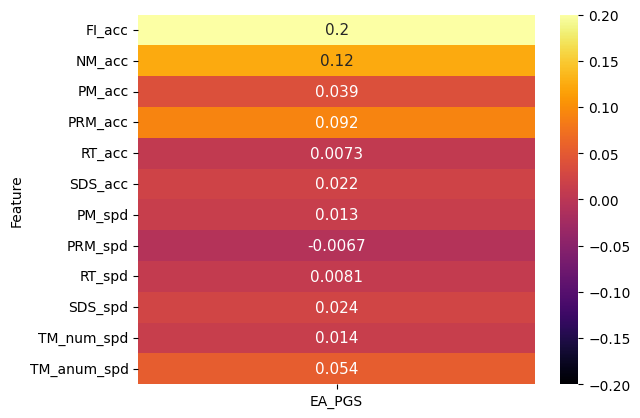

In [80]:
pattern = r'(acc.*|spd.*|EA)'
EA_df = df_psych.filter(regex=pattern)
EA_df
# SCZ_df = merged_df.iloc[:,:-3]
# SCZ_df = SCZ_df.iloc[: , 1:]

corr_df_EA = perform_correlation(EA_df, "EA_PGS")

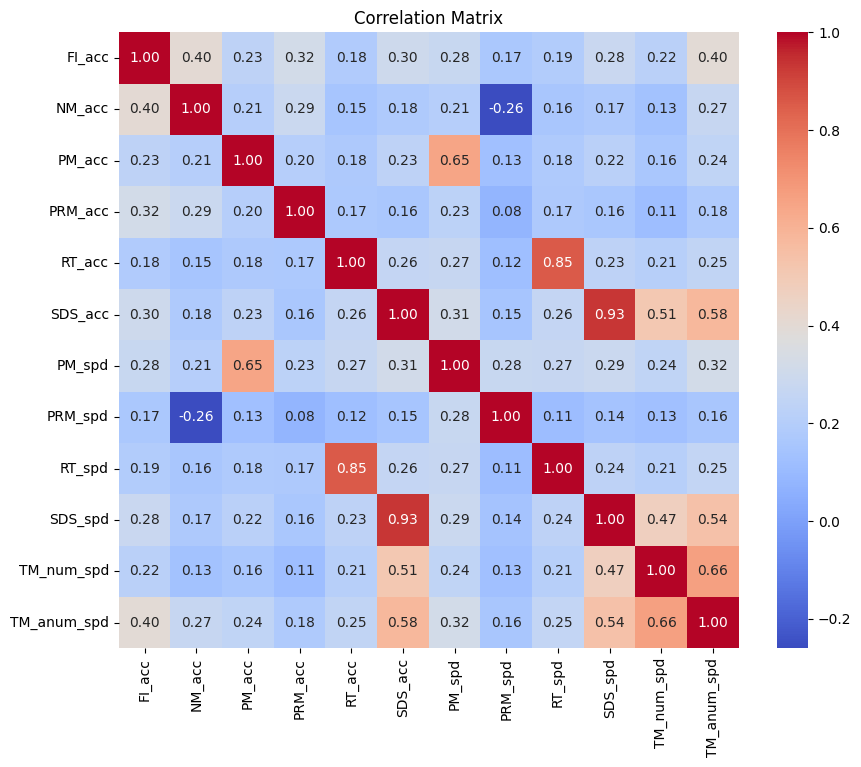

In [81]:
# 1.  Check for Multicollinearity

# Compute the correlation matrix
corr_matrix = cog_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [83]:
cog_df.to_csv('cog_res.tsv', sep='\t')